# Deep learning Morpion Solitaire

In [82]:
from tqdm.notebook import trange
import ipywidgets as widgets
#from pathlib import Path

This function simply picks at random one of the allowed moves at any stage of the game

## Generate initial data

In [83]:
from MorpionSolitaire import *

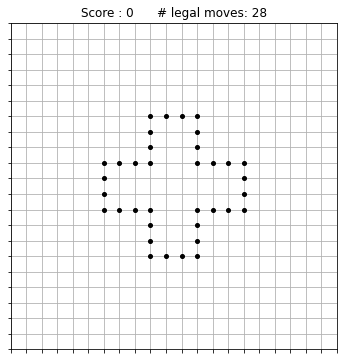

In [84]:
base = StartingGame()
base.print()

In [85]:
def pickatrandom(game): return np.random.randint(len(game.moves))

The algorithm that we are going to use is the following:
1. Play a game at random until the end
2. Rewind at random to an arbitrary intermediate step that we will call `exploration_game`
3. From this intermediate step, explore at random the possible completions, and keep the best score
4. Associate to the image of `exploration_game` the maximal score and save the image file.
The file name takes the following format: `id#####s###.png`, where the first 5-digit number is a unique identifier and the second 3-digit number the label, i.e. the number of expected moves remaing

Finally, repeat this loop as often as necessary to generate enough data.

The two parameters that control this data are:
- `n_games`: total number of games to be played (i.e. how many images are generated)
- `n_completions`: for each game, how many random completions do we perform


In [86]:
n_games = 1000
n_completions = 20
path = 'random_data/'

In [87]:
xdata = []
ydata = []
for i in trange(n_games):
    # 1. play at random
    random_game = base.play(pickatrandom)
    # 2. rewind
    exploration_game = random_game.get_parent(np.random.randint(random_game.score))
    # 3. explore completions
    best_score = random_game.score
    for _ in range(1,n_completions):
        random_game = exploration_game.play(pickatrandom)
        if random_game.score > best_score:
            best_score = random_game.score
    # 4. explore completions
    expectation = best_score - exploration_game.score
    xdata.append(exploration_game.score)
    ydata.append(expectation)
#     im = exploration_game.grid.image()
#     label = '{}id{:05}s{:03}.png'.format(path, i, expectation)
#     im.save(label)

Frequency of scores in the data:

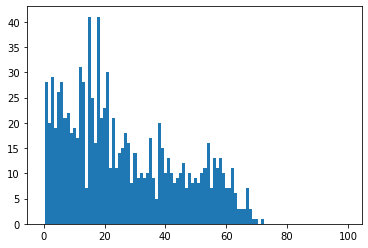

In [88]:
plt.hist(xdata, bins=100, range=(-0.5,99.5))
plt.show()

Frequency of labels in the data:

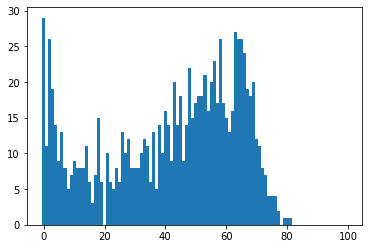

In [89]:
plt.hist(ydata, bins=100, range=(-0.5,99.5))
plt.show()

Comparison with the baseline model:

In [90]:
expdata = np.load('rand_expectation.npy')

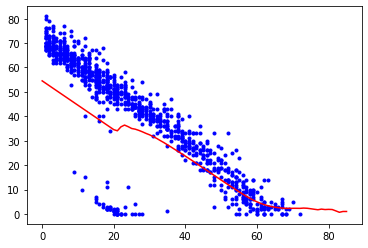

In [91]:
plt.scatter(xdata, ydata, color = 'b', marker = '.')
plt.plot(expdata, color = 'r')
plt.show()

Loss function for deep learning:

In [149]:
def baseline_fct(image):
    score = np.array(image).astype(int)[0::3,0::3].sum() - 36
    if score < len(expdata):
        return expdata[score]
    return 0

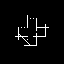

In [150]:
im = exploration_game.grid.image()
im

In [151]:
(baseline_fct(im), ydata[-1])

(44.5269, 61)

In [152]:
datainput = np.array([expdata[n] for n in xdata])
datatarget = np.array(ydata)

In [153]:
dataloss = np.abs((datainput + 1)/(datatarget + 1)).mean()
dataloss

1.7118751023582761

## Deep learning: first round

In Google Colab, needs to upgrade `fastai` to newest version:

In [ ]:
!pip install --upgrade fastai

Load `fastai` library:

In [28]:
from fastai.basics import *
from fastai.vision.all import *

Untar data when running locally:

In [ ]:
!ls -l

In [65]:
!tar -xf 'random_data.tar.gz'
!ls -l

total 2828
-rw-rw-r-- 1 marc marc  131918 Jan 19 10:08 Deep_Learning.ipynb
-rw-rw-r-- 1 marc marc  263617 Jan 18 14:00 documentation.ipynb
-rw-rw-r-- 1 marc marc   12971 Jan 18 12:22 MorpionSolitaire.py
drwxrwxr-x 2 marc marc    4096 Jan 18 12:22 __pycache__
-rw-rw-r-- 1 marc marc     816 Jan 16 18:44 rand_expectation.npy
drwxrwxr-x 2 marc marc  483328 Jan 18 16:15 random_data
-rw-rw-r-- 1 marc marc 1937616 Jan 18 16:17 random_data.tar.gz
-rw-rw-r-- 1 marc marc   33097 Jan 18 13:59 Random_Exploration.ipynb
-rw-rw-r-- 1 marc marc    1316 Jan 16 12:59 README.md


Untar data when running in Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls -l 'gdrive/MyDrive/Colab Notebooks/'

In [ ]:
!tar -xf 'gdrive/MyDrive/Colab Notebooks/random_data.tar.gz'
!ls -l 'random_data'

Definining the current path

In [67]:
path = Path('random_data/')

In [68]:
path.ls()

(#10000) [Path('random_data/id05108s001.png'),Path('random_data/id07614s058.png'),Path('random_data/id05281s032.png'),Path('random_data/id09584s066.png'),Path('random_data/id07250s041.png'),Path('random_data/id01955s023.png'),Path('random_data/id06182s057.png'),Path('random_data/id09709s040.png'),Path('random_data/id09703s066.png'),Path('random_data/id05283s049.png')...]

Read label (y) from file name:
(could be made nicer using regex, but not really needed here)

In [25]:
def get_label(x): return int(x[-7:-4])

Data loader:

In [208]:
gamesdata = DataBlock(blocks = (ImageBlock, RegressionBlock),
                      get_items=get_image_files,
                      splitter=RandomSplitter(seed=42),
                      get_y=using_attr(get_label, 'name')) #batch_tfms=
dls = gamesdata.dataloaders(path)

To be implemented at this stage: data augmentation, by passing a function to `batch_tfms`

In [209]:
doc(aug_transforms)

Verify that `dls` does the right thing:

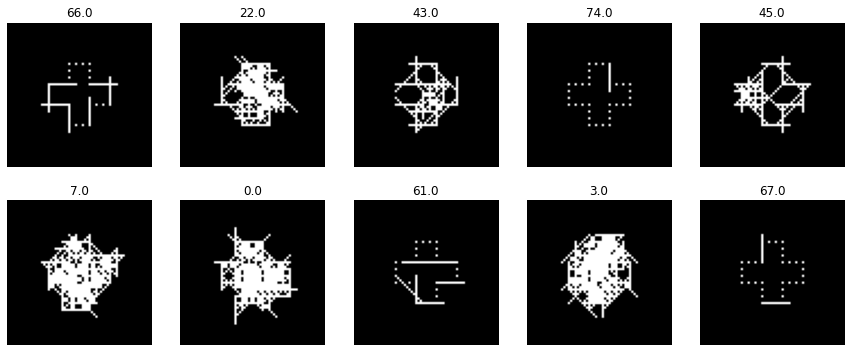

In [210]:
dls.valid.show_batch(max_n=10, nrows=2)

Looking at one batch in more details:

In [220]:
# onebatch = list(dls.train)[0]

In [221]:
# len(onebatch)

In [222]:
# onebatch[1]

In [223]:
# onebatch[0].shape

Loss function:

In [211]:
def ms_loss(inputs, targets):
    return torch.abs((torch.exp(inputs) + 1)/(targets + 1) - 1).mean()

Metric:

In [224]:
def ms_metric(predictions, targets):
    return torch.where(torch.round(torch.exp(predictions)) == targets, 1.0, 0.0).mean()

Training:

In [225]:
learn = cnn_learner(dls, resnet18, pretrained = False, 
                    loss_func = ms_loss, metrics = ms_metric)

In [ ]:
learn.fine_tune(1)